# Music-Learning

## Introduction and scope of the notebook
This notebook aims to show the application of Machine Learning models to solve the problem of music genre recognition.

This problem is well know and studied by the literature, since it has a wide set of applications.

For the data we used the [FMA dataset](https://github.com/mdeff/fma), which contains differents zips of .mp3 audio files.
Given the size of the zip, we decided to use the __medium__ version to extract the feature and the classification is performed on the top 16 root genres that are explained in more details in [`1`](https://arxiv.org/abs/1612.01840).

In [4]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.svm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_score, auc, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel, RFE, RFECV
from sklearn.preprocessing import LabelEncoder

# Classifiers
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

import librosa
import librosa.display

import ast
import os
import cmath

# utility imports from .py files
from plot_utils import basic_plot, bar_plot
from dataset_utils import drop_complex_cols, get_top_genres, load
from utils import write_cm_on_file

We present two versions of the notebook, associated with the two binary value of  '__VERSION__':
1. 0: use the dataset from FMA repository
1. 1: use our dataset, extracted by the mp3 archive of the FMA repository

In [5]:
VERSION = 1

## Data preprocessing
There is the need to do some preliminar operations on the data extracted by the .mp3 files:

1. First, there are some columns (the 'Fourier' related) that have complex numbers as values.
These values can't be treated by the ML models so are discared

2. The labels have to be encoded to be processed in the right way

In [42]:
# Open file, extract feature set and label set
if VERSION:
    path = "out.csv"
    dataframe = pd.read_csv(path)
    y = dataframe["genre"]
    dataframe = dataframe.drop(columns=["title", "artist", "filename", "album", "genre"])
    X = dataframe.drop(columns=drop_complex_cols(dataframe))

    # Label encoding and extraction of uniques for later purposes
    le = LabelEncoder()
    y = le.fit_transform(y)
    labels = pd.Series(y).unique()
    
else:
    path = "dataset/fma_metadata/"
    tracks_file = "tracks.csv"
    features_file = "features.csv"
    ds_features = load(path+features_file)
    ds_tracks = load(path+tracks_file)
    medium = ds_tracks['set', 'subset'] <= 'medium'
    X = ds_features.loc[medium, 'mfcc']
    y = ds_tracks.loc[medium, ('track', 'genre_top')]
    labels = y.unique()


# Split into train/validate/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.10)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, 
                                                            random_state=42, test_size=0.10)

## SVM
The first classifier that we evaluate is Support Vector Machine.<br>
Based on the online literature, the suited kernel function seems to be 'rfb', so it was our choice to use it too.

### Parameter tuning
Tuning was made to find the suited value for $C$

In [ ]:
C_values = [1, 2, 5, 10, 15, 20]
svm_scores = []

for C in C_values:
    svm_clf = skl.svm.SVC(C=C, kernel='rbf').fit(X_train, y_train)
    svm_scores.append(np.asarray(cross_val_score(svm_clf, X_validate, y_validate, cv=2)).mean())
    
basic_plot((16,9), C_values, svm_scores, "C value", "Accuracy", 
           "Accuracy for different C values for SVM classifier")

In [ ]:
# Given which is the best value of C, we train evaluate and test the model
# saving the results.
C_best = 20
svm_clf = skl.svm.SVC(C=C_best, kernel='rbf').fit(X_train, y_train)
print(cross_val_score(svm_clf, X_validate, y_validate, cv=2))  # print validation score

svm_predictions = svm_clf.predict(X_test)
print(svm_clf.score(X_test,y_test))                           # print accuracy

# Gather metrics
if VERSION:
    svm_precision = precision_score(y_test, svm_predictions, average=None, labels=labels)
    svm_recall = recall_score(y_test, svm_predictions, average=None, labels=labels)
    svm_f1 = f1_score(y_test, svm_predictions, average=None, labels=labels)
    svm_cm = confusion_matrix(y_test, svm_predictions, labels=labels)
    
else:
    svm_precision_fma = precision_score(y_test, svm_predictions, average=None, labels=labels)
    svm_recall_fma = recall_score(y_test, svm_predictions, average=None, labels=labels)
    svm_f1_fma = f1_score(y_test, svm_predictions, average=None, labels=labels)
    svm_cm_fma = confusion_matrix(y_test, svm_predictions, labels=labels)

print("------------------------- SVM completed -------------------------")

In [8]:
# Output the confusion matrix on a .csv file
string_labels = le.inverse_transform(labels)
write_cm_on_file(cm=svm_cm, labels=string_labels, path="confusion_matrix_svm.csv")

## LR
The second classifier used is Logistic Regression

### Model tuning
Here, we evaluated different solvers with their penality

In [ ]:
model_solv = {'newton-cg':'l2', 'sag':'l2', 'saga':'l1', 'lbfgs':'l2'}
lr_scores = []
for solver in model_solv:
    lr_clf = LogisticRegression(C=1, penalty=model_solv[solver], dual=False, solver=solver).fit(
        X_train, y_train)
    lr_scores.append(np.asarray(cross_val_score(lr_clf, X_validate, y_validate, cv=2)).mean())
bar_plot((16,9), lr_scores, list(model_solv.keys()), "Accuracy for different model solvers for LR")
    #basic_plot((16,9), lr_scores, , "# hidden layers", "Accuracy", 
     #      "Accuracy for different # of hidden layers for MLP classifier")

In [11]:
solver = "saga"
penalty = 'l1' 
lr_clf = LogisticRegression(C=1, penalty="l1", dual=False, solver='saga').fit(X_train, y_train)
    #lr_clf.fit(X_train, y_train)
print(np.asarray(cross_val_score(lr_clf, X_validate, y_validate, cv=2)).mean())
lr_predictions = lr_clf.predict(X_test) 
print(lr_clf.score(X_test, y_test))

if VERSION:
    lr_precision = precision_score(y_test, lr_predictions, average=None, labels=labels)
    lr_recall = recall_score(y_test, lr_predictions, average=None, labels=labels)
    lr_f1 = f1_score(y_test, lr_predictions, average=None, labels=labels)
    lr_cm = confusion_matrix(y_test, lr_predictions, labels=labels)
else:
    lr_precision_fma = precision_score(y_test, lr_predictions, average=None, labels=labels)
    lr_recall_fma = recall_score(y_test, lr_predictions, average=None, labels=labels)
    lr_f1_fma = f1_score(y_test, lr_predictions, average=None, labels=labels)
    lr_cm_fma = confusion_matrix(y_test, lr_predictions, labels=labels)

print("------------------------- LR completed -------------------------")

/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.44543556580593613
0.4823965410747375
------------------------- LR completed -------------------------


/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## kNN
As third classifier we have k-Nearest-Neighbours.

## Model tuning
Tuning was made on the value for parameter $k$

/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: Us

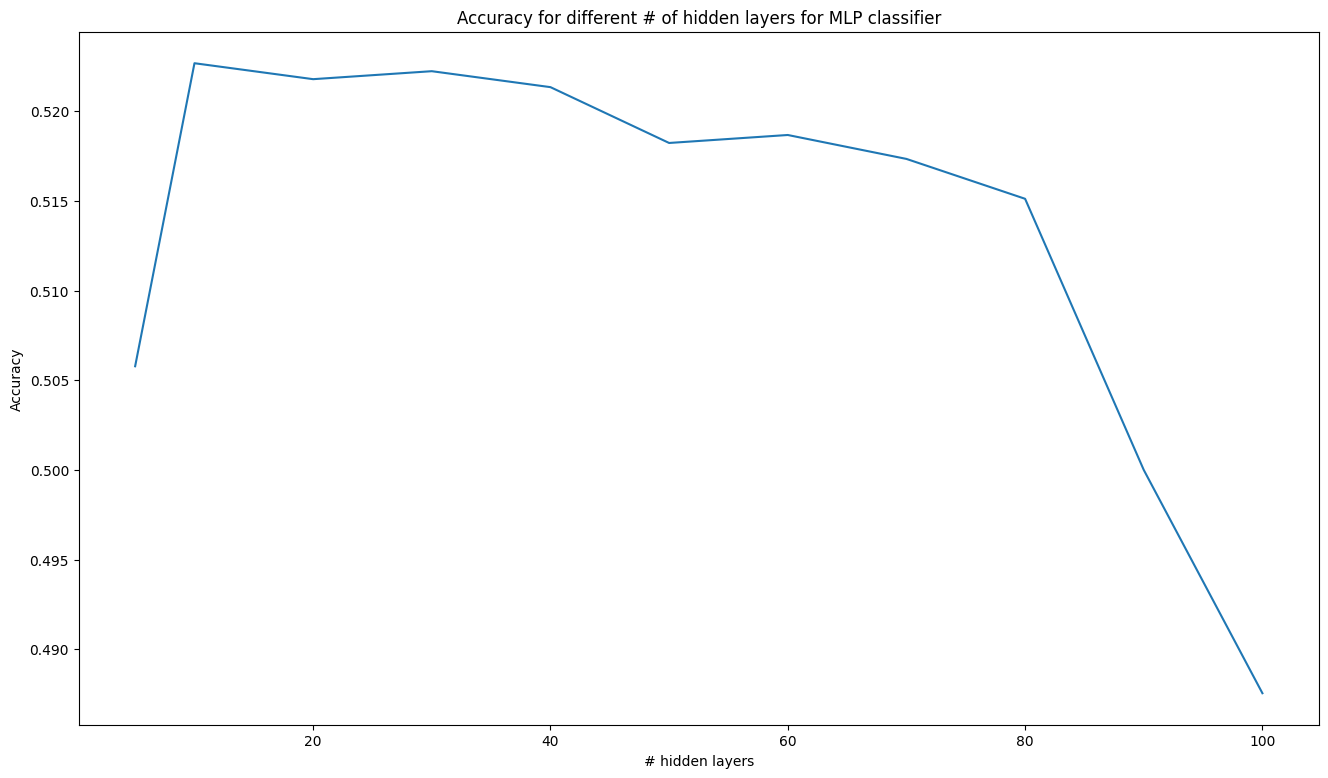

In [21]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.10)
#X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, random_state=42, 
                                                            #test_size=0.10)
k_values = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
knn_scores = []
for k in k_values:
    knn_clf = KNeighborsClassifier(k)
    knn_clf.fit(X_train, y_train)
    knn_scores.append(np.asarray(cross_val_score(knn_clf, X_validate, y_validate, cv=2)).mean())
    
basic_plot((16,9), k_values, knn_scores, "# hidden layers", "Accuracy", 
           "Accuracy for different # of hidden layers for MLP classifier")

In [14]:
# the actual classification
n_neighbors_best = 5
knn_clf = KNeighborsClassifier(n_neighbors_best)

knn_clf.fit(X_train, y_train)
print(np.asarray(cross_val_score(knn_clf, X_validate, y_validate, cv=2)).mean())
knn_predictions = knn_clf.predict(X_test)

print(knn_clf.score(X_test, y_test))

if VERSION:
    knn_precision = precision_score(y_test, knn_predictions, average=None, labels=labels)
    knn_recall = recall_score(y_test, knn_predictions, average=None, labels=labels)
    knn_f1 = f1_score(y_test, knn_predictions, average=None, labels=labels)
    knn_cm = confusion_matrix(y_test, knn_predictions, labels=labels)
else:
    knn_precision_fma = precision_score(y_test, knn_predictions, average=None, labels=labels)
    knn_recall_fma = recall_score(y_test, knn_predictions, average=None, labels=labels)
    knn_f1_fma = f1_score(y_test, knn_predictions, average=None, labels=labels)
    knn_cm_fma = confusion_matrix(y_test, knn_predictions, labels=labels)


print("------------------------- kNN completed -------------------------")

0.3768013536532055
0.42927733168622606
------------------------- kNN completed -------------------------


/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## MLP
The last classifier considered was Multi Layer Perceptron

/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/lib/python3.10/site-packages/sklearn/neural_networ

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_ite

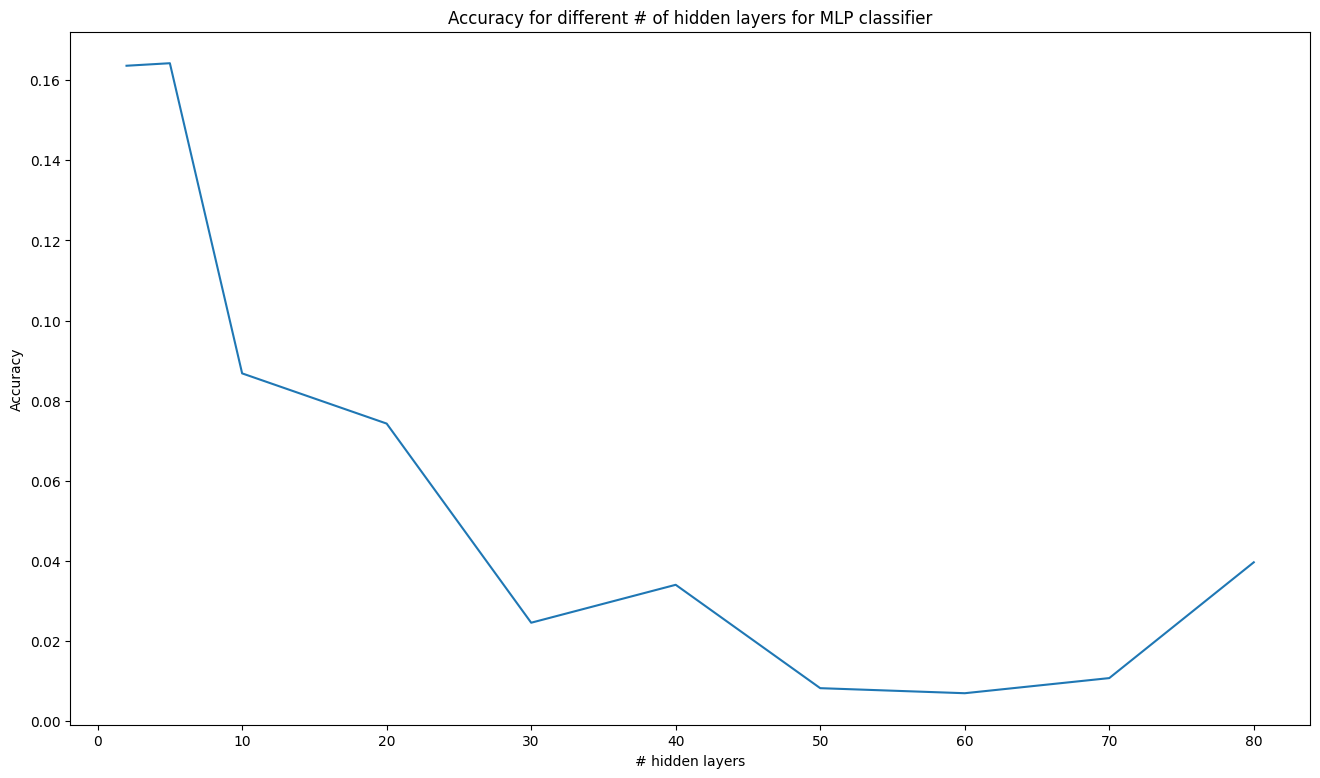

In [9]:
# Tuning for the value of the hidden layers
'''
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.10)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, random_state=42, 
                                                            test_size=0.10)
                                                            '''
hlayers = [2, 5, 10, 20, 30, 40, 50, 60, 70, 80]
mlp_scores = []
for h_layer in hlayers:
    mlp_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(h_layer,), 
                            random_state=1)
    mlp_clf.fit(X_train, y_train)
    mlp_scores.append(np.asarray(cross_val_score(mlp_clf, X_validate, y_validate, cv=2)).mean())
    
basic_plot((16,9), hlayers, mlp_scores, "# hidden layers", "Accuracy", 
           "Accuracy for different # of hidden layers for MLP classifier")

In [15]:
n_hidden_opt = 5
mlp_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(n_hidden_opt,), 
                            random_state=1)
mlp_clf.fit(X_train, y_train)
print(np.asarray(cross_val_score(mlp_clf, X_validate, y_validate, cv=2)).mean())
mlp_predictions = mlp_clf.predict(X_test)

print(mlp_clf.score(X_test, y_test))

if VERSION:
    mlp_precision = precision_score(y_test, mlp_predictions, average=None, labels=labels)
    mlp_recall = recall_score(y_test, mlp_predictions, average=None, labels=labels)
    mlp_f1 = f1_score(y_test, mlp_predictions, average=None, labels=labels)
    mlp_cm = confusion_matrix(y_test, mlp_predictions, labels=labels)
else:
    mlp_precision_fma = precision_score(y_test, mlp_predictions, average=None, labels=labels)
    mlp_recall_fma = recall_score(y_test, mlp_predictions, average=None, labels=labels)
    mlp_f1_fma = f1_score(y_test, mlp_predictions, average=None, labels=labels)
    mlp_cm_fma = confusion_matrix(y_test, mlp_predictions, labels=labels)
    

0.14696200575830204
0.2711550339715874


/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Decision Three
As fifth and last classifier, we used decision three. 

### Parameter tuning
Some tuning (ha un botto di parametri Decision Tree...)

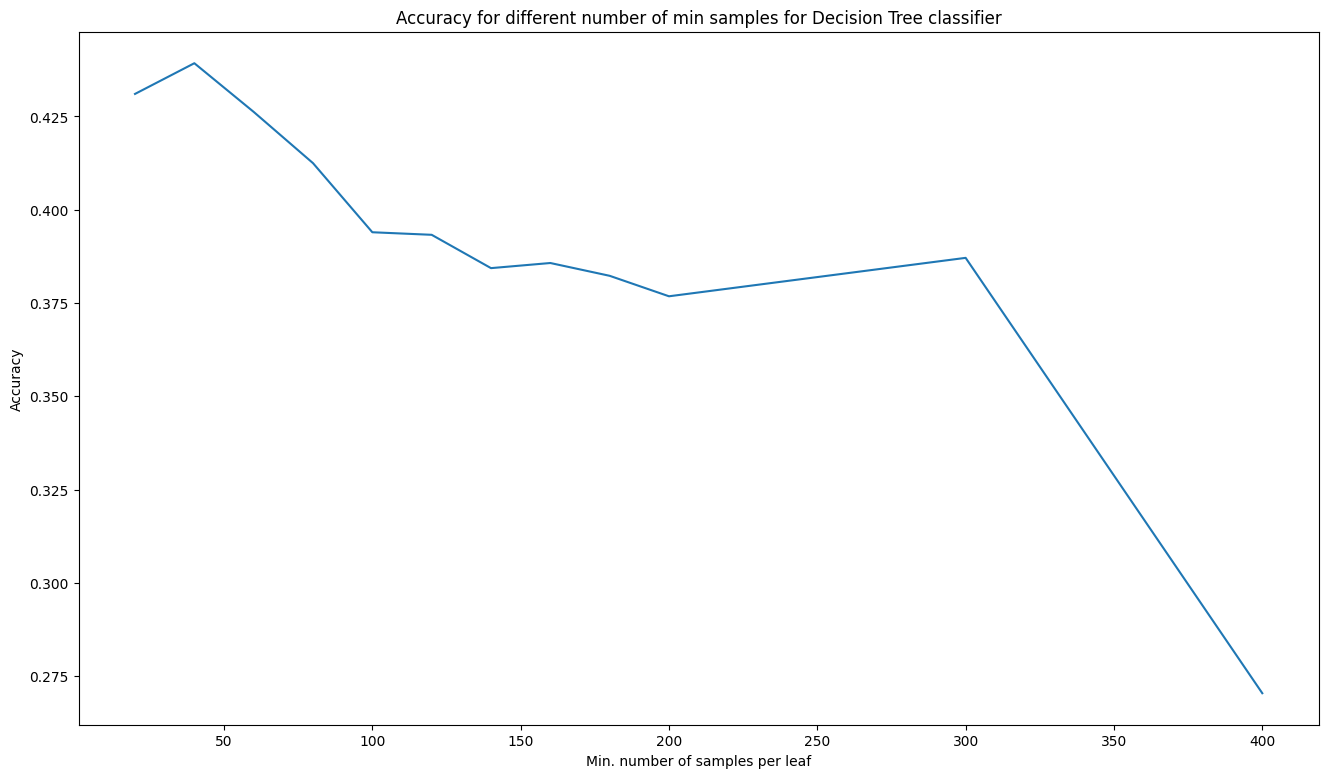

In [41]:
min_samples_leafs = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 300, 400]
dt_scores = []
for min_samples_leaf in min_samples_leafs:
    dt_clf = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf).fit(X_train, y_train)
    dt_scores.append(np.asarray(cross_val_score(dt_clf, X_validate, y_validate, cv=2)).mean())
basic_plot((16,9), min_samples_leafs, dt_scores, "Min. number of samples per leaf", "Accuracy", 
        "Accuracy for different number of min samples for Decision Tree classifier")

In [39]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(min_samples_leaf=40).fit(X_train, y_train)
print(np.asarray(cross_val_score(dt_clf, X_validate, y_validate, cv=2)).mean())
print(dt_clf.score(X_test, y_test))

0.43925518925518925
0.4990735021618283


## Classifiers metrics and comparison
Last, we evaluate performance metrics for the different classifiers and compare the
results obtained.

We compute 4 different metrics for each classifier:

| Metric | Expression|
|:-------- | :-------------------------------------------------: |
| Accuracy | $\tfrac{TN + TP}{TP+FP+TN+FN}$ |
| Precision | $\tfrac{TP}{TP + FP}$ |
| Recall | $\tfrac{TP}{TP + FN}$ |
| F1-score | $2 \cdot \tfrac{Precision \cdot Recal}{Precision + Recal}$ |

were:
- TN is the number of True Negative instances
- TP is the number of True Positive instances
- FP is the number of False Positive instances
- FN is the number of False Negative instances

<br><br>
N.B: given the fact that the dataset is not well balanced (i.e: there is not the same amount of samples for each class) the accuracy metrics gets impacted so it is not the best metric to takes into account.
That's the reason why we decided to show other metrics that are less affected by dataset balance.

---------------------------------------------------------------------------------------

SVM results:


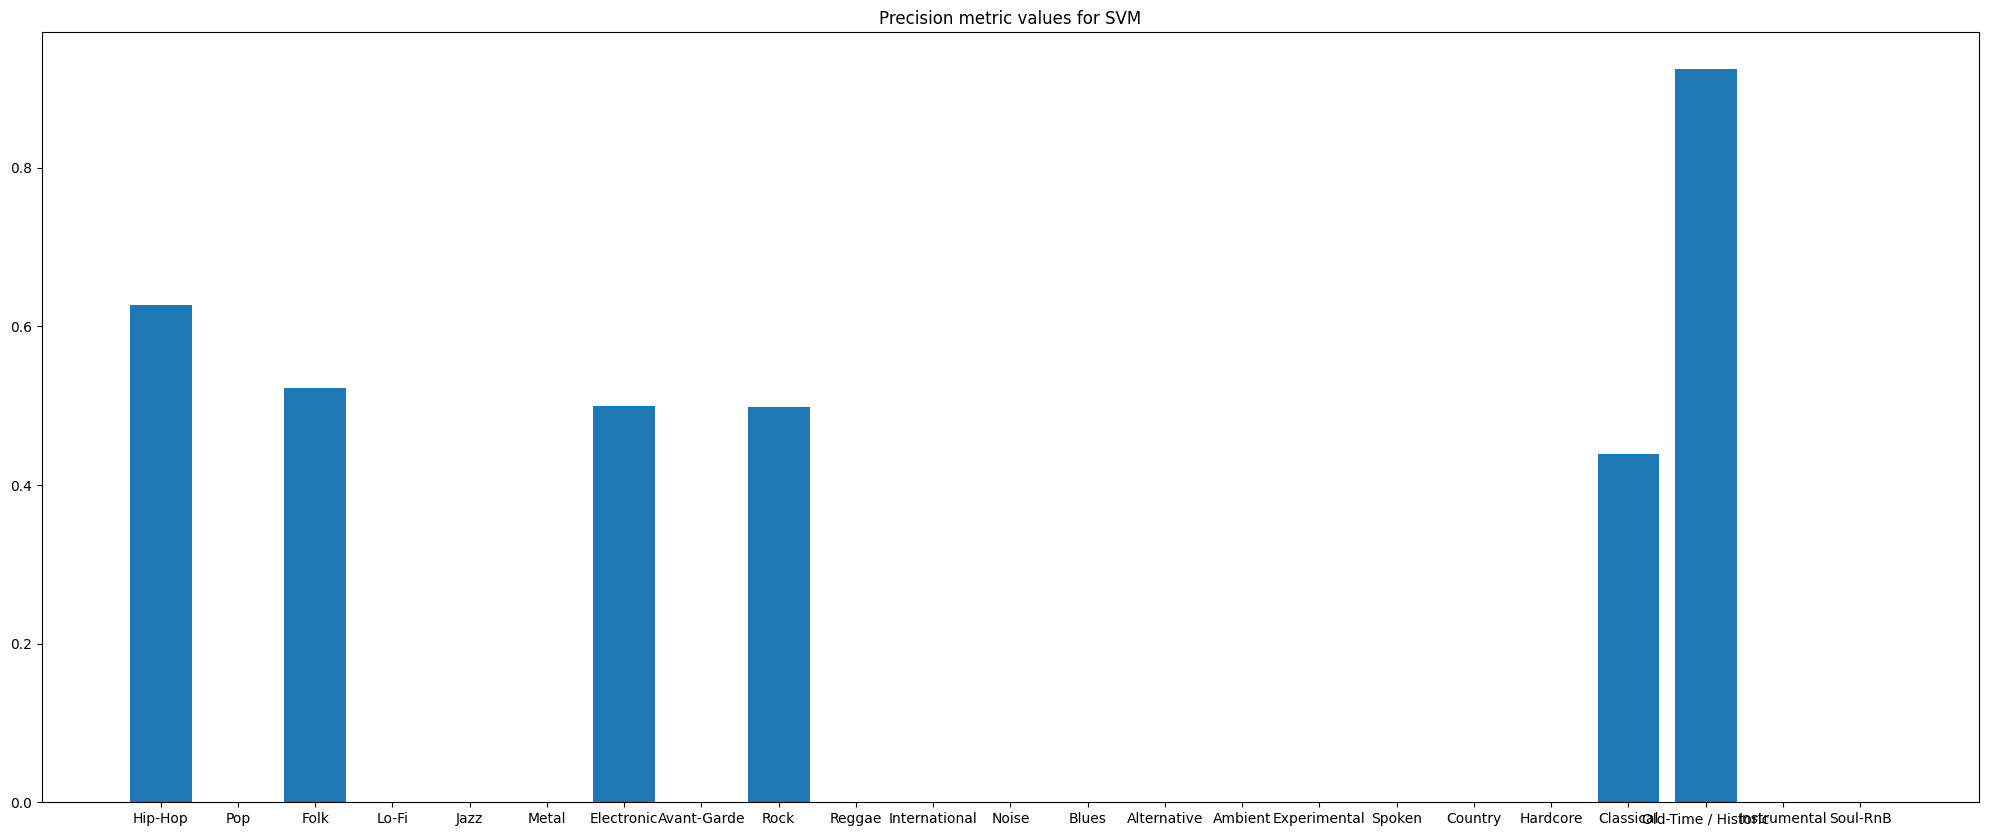

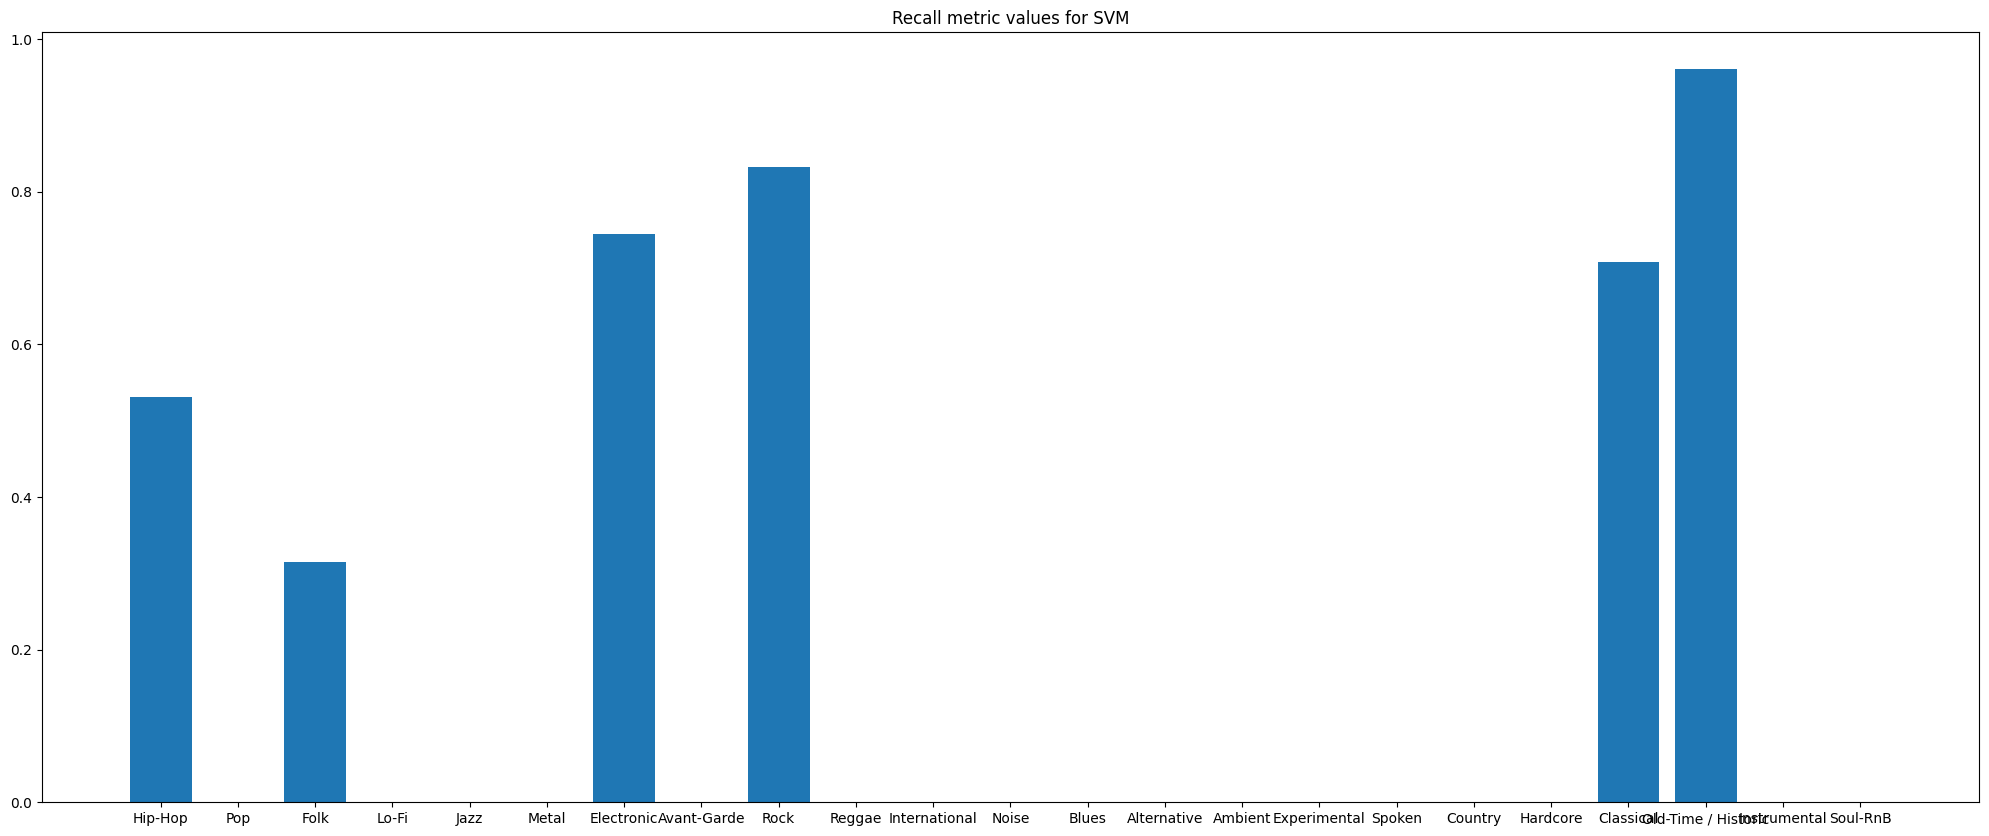

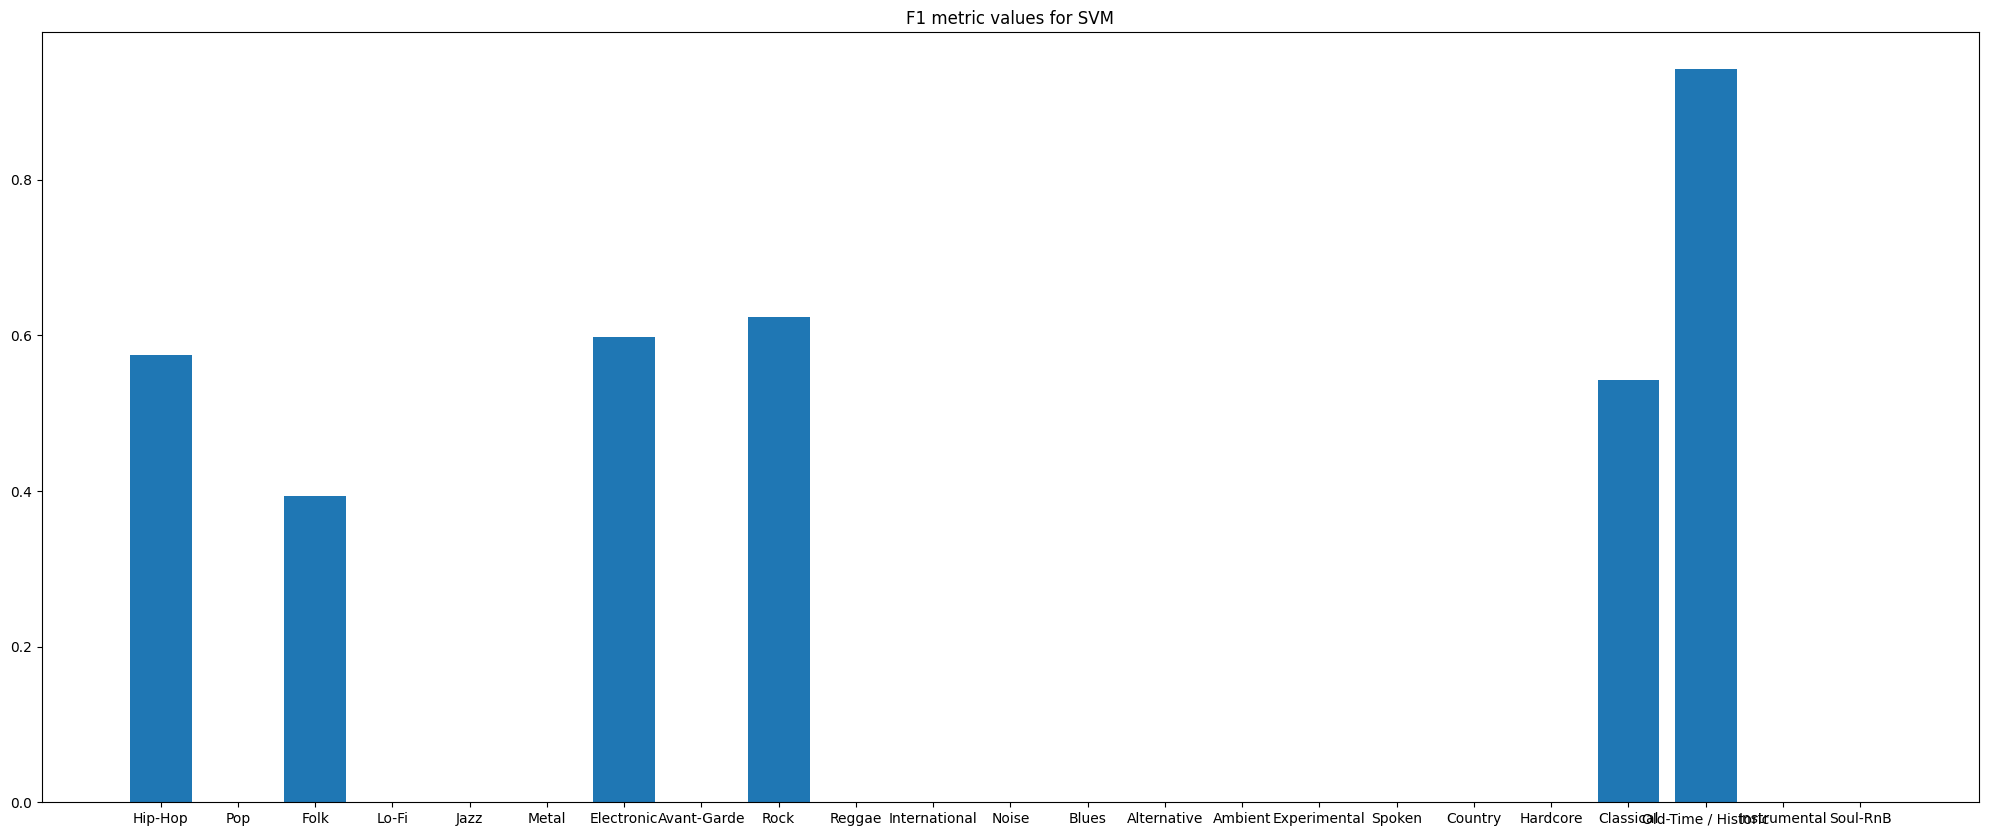

---------------------------------------------------------------------------------------

kNN results: 


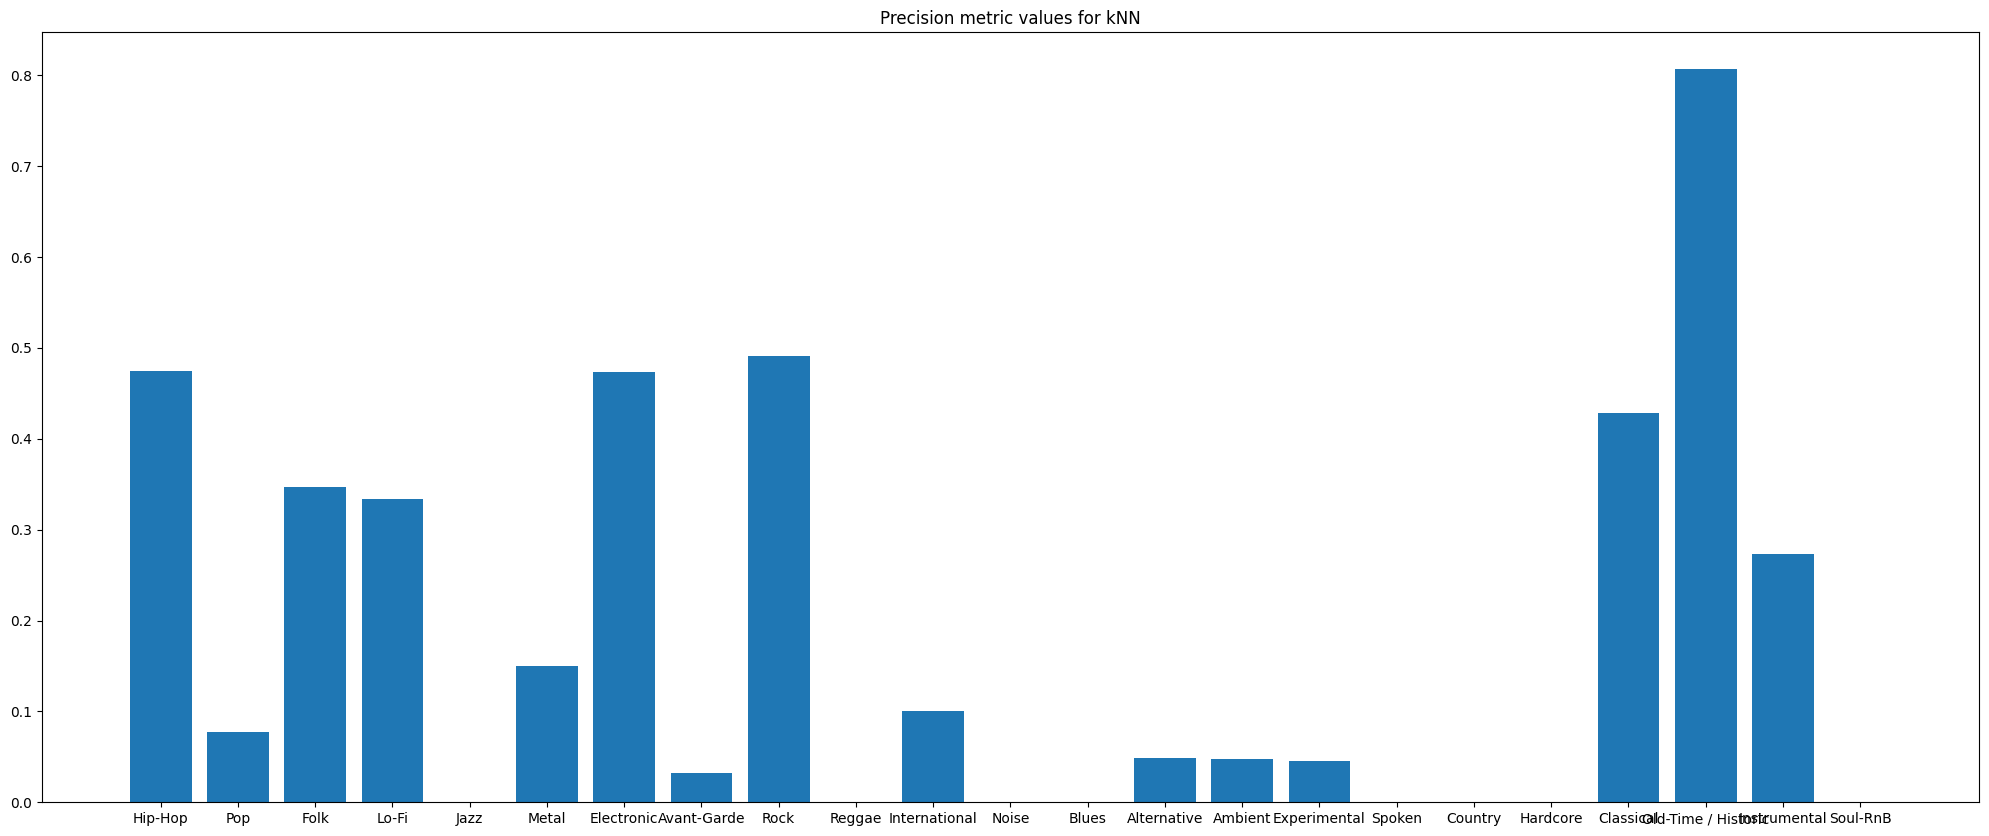

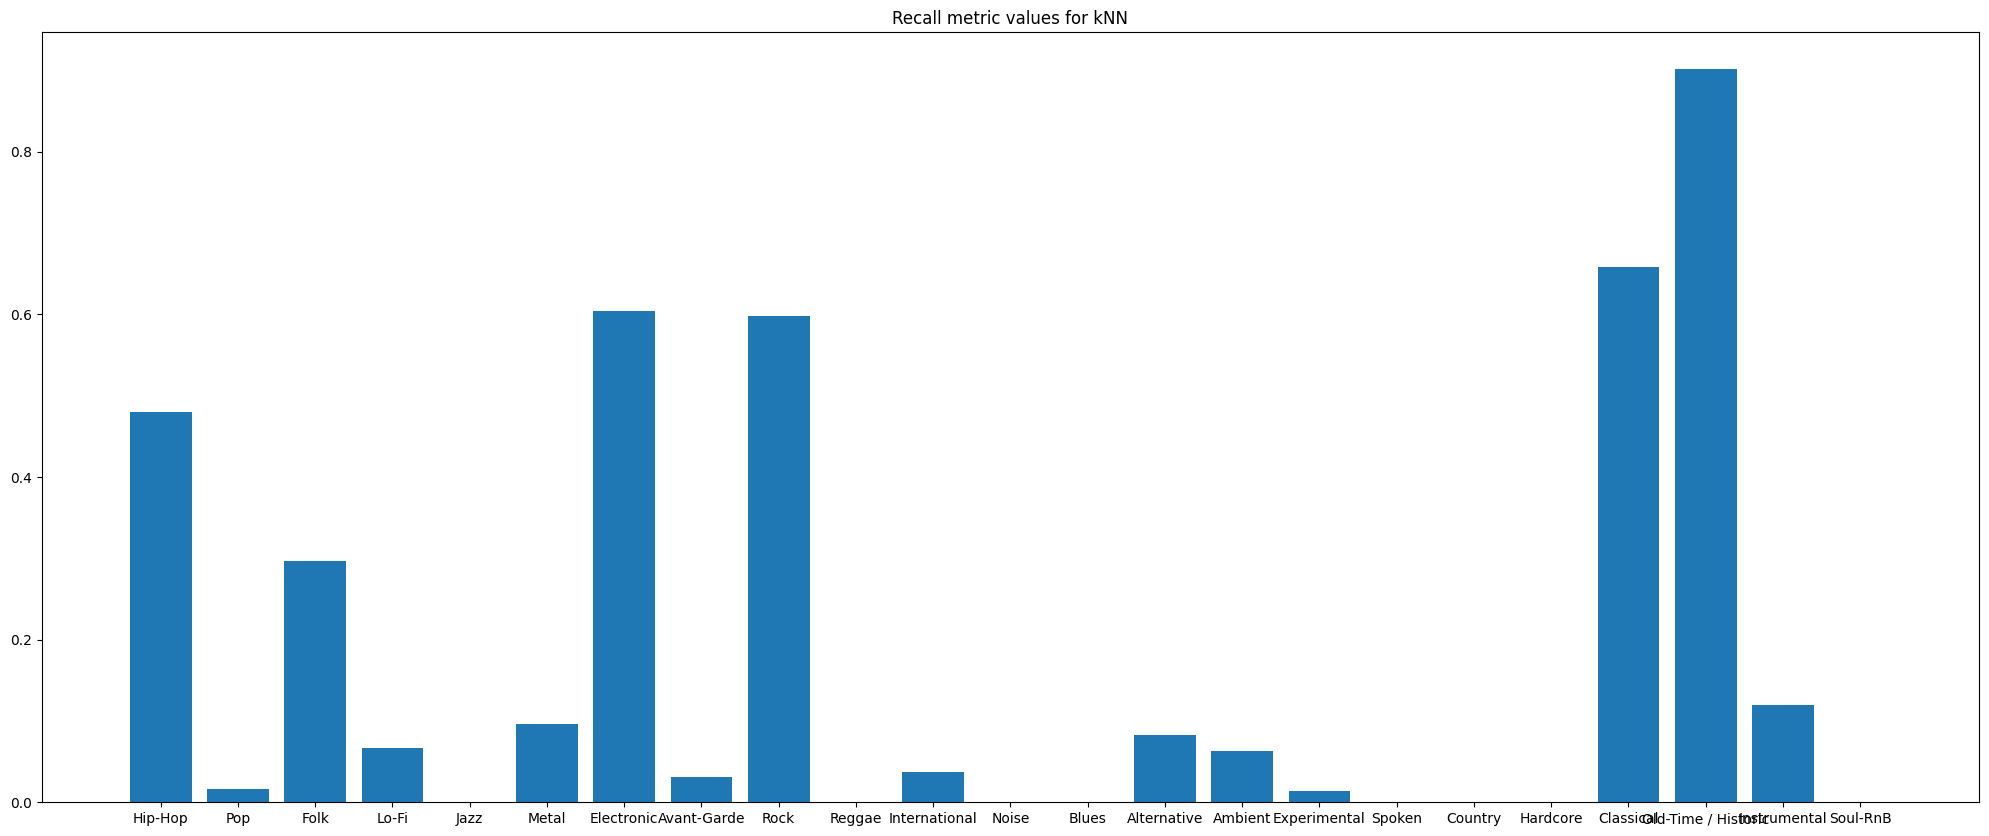

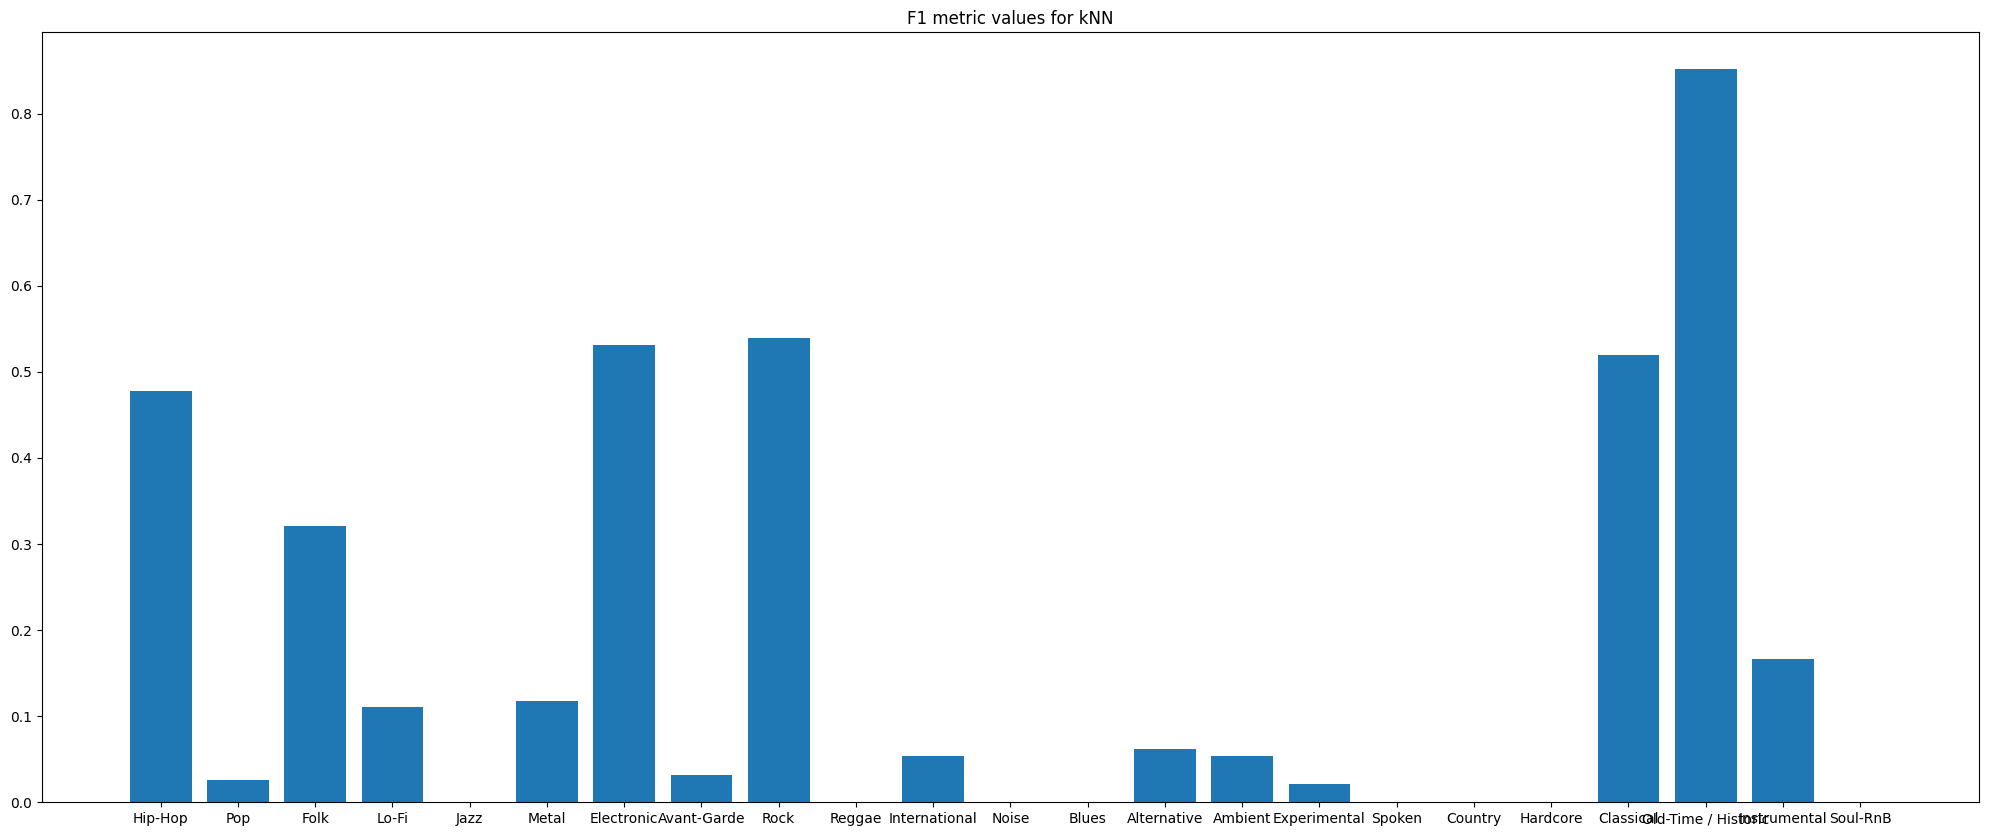

---------------------------------------------------------------------------------------

Linear Regression results: 


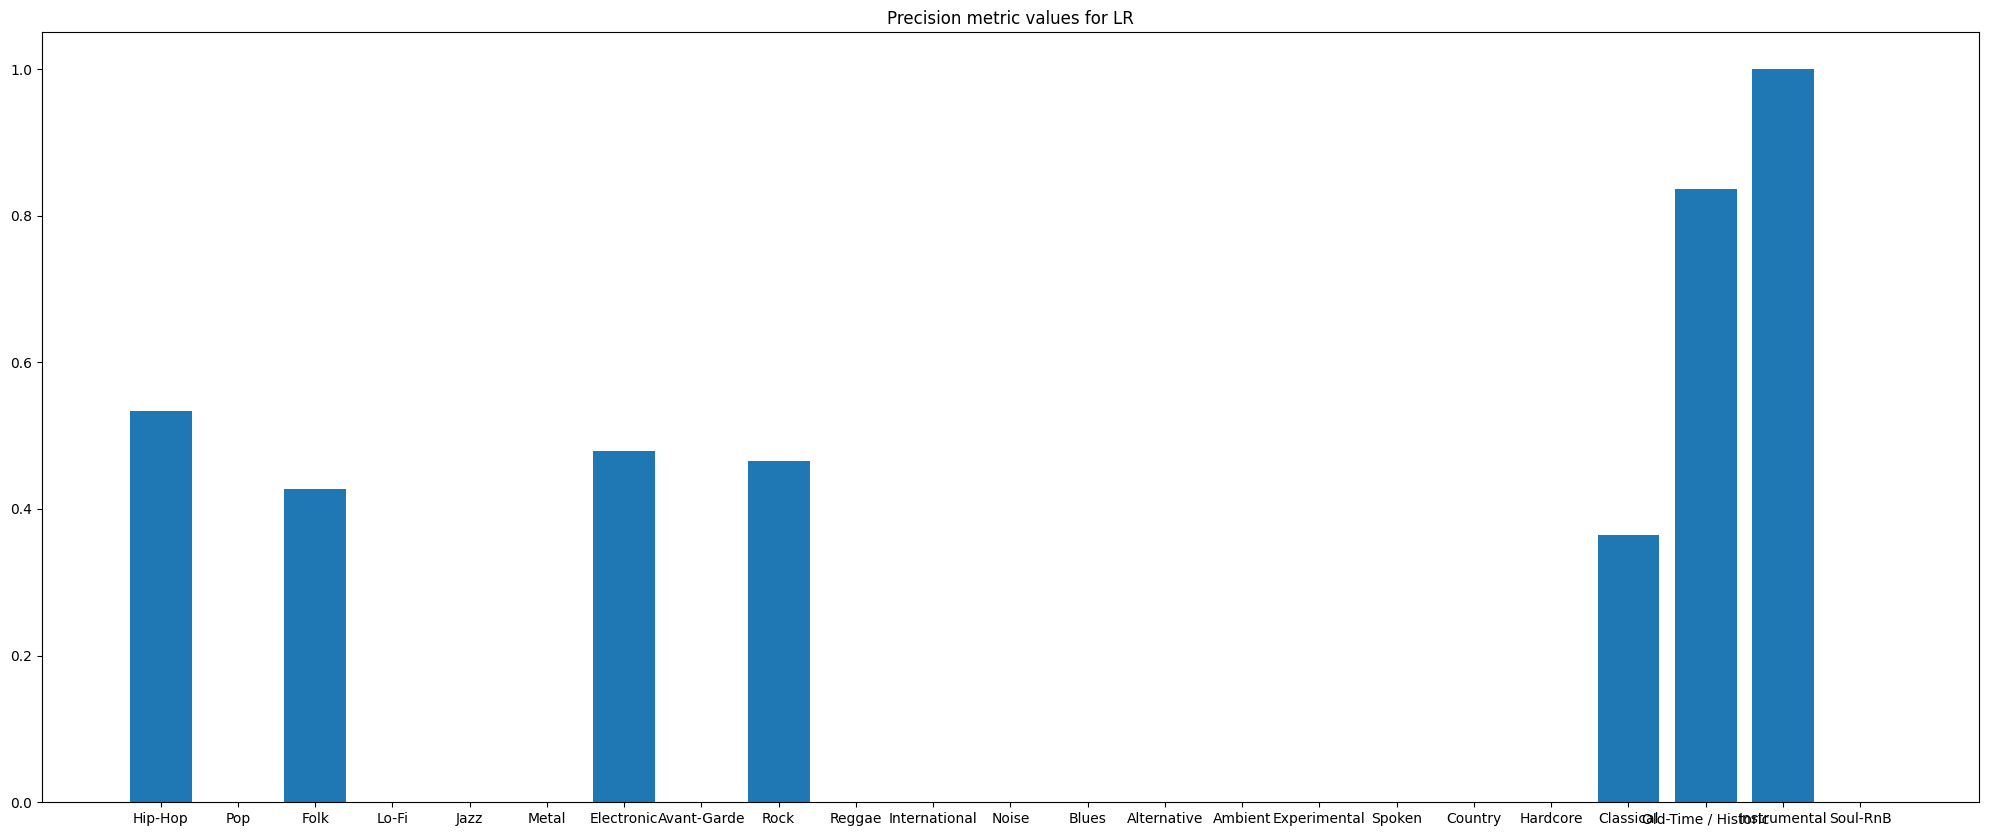

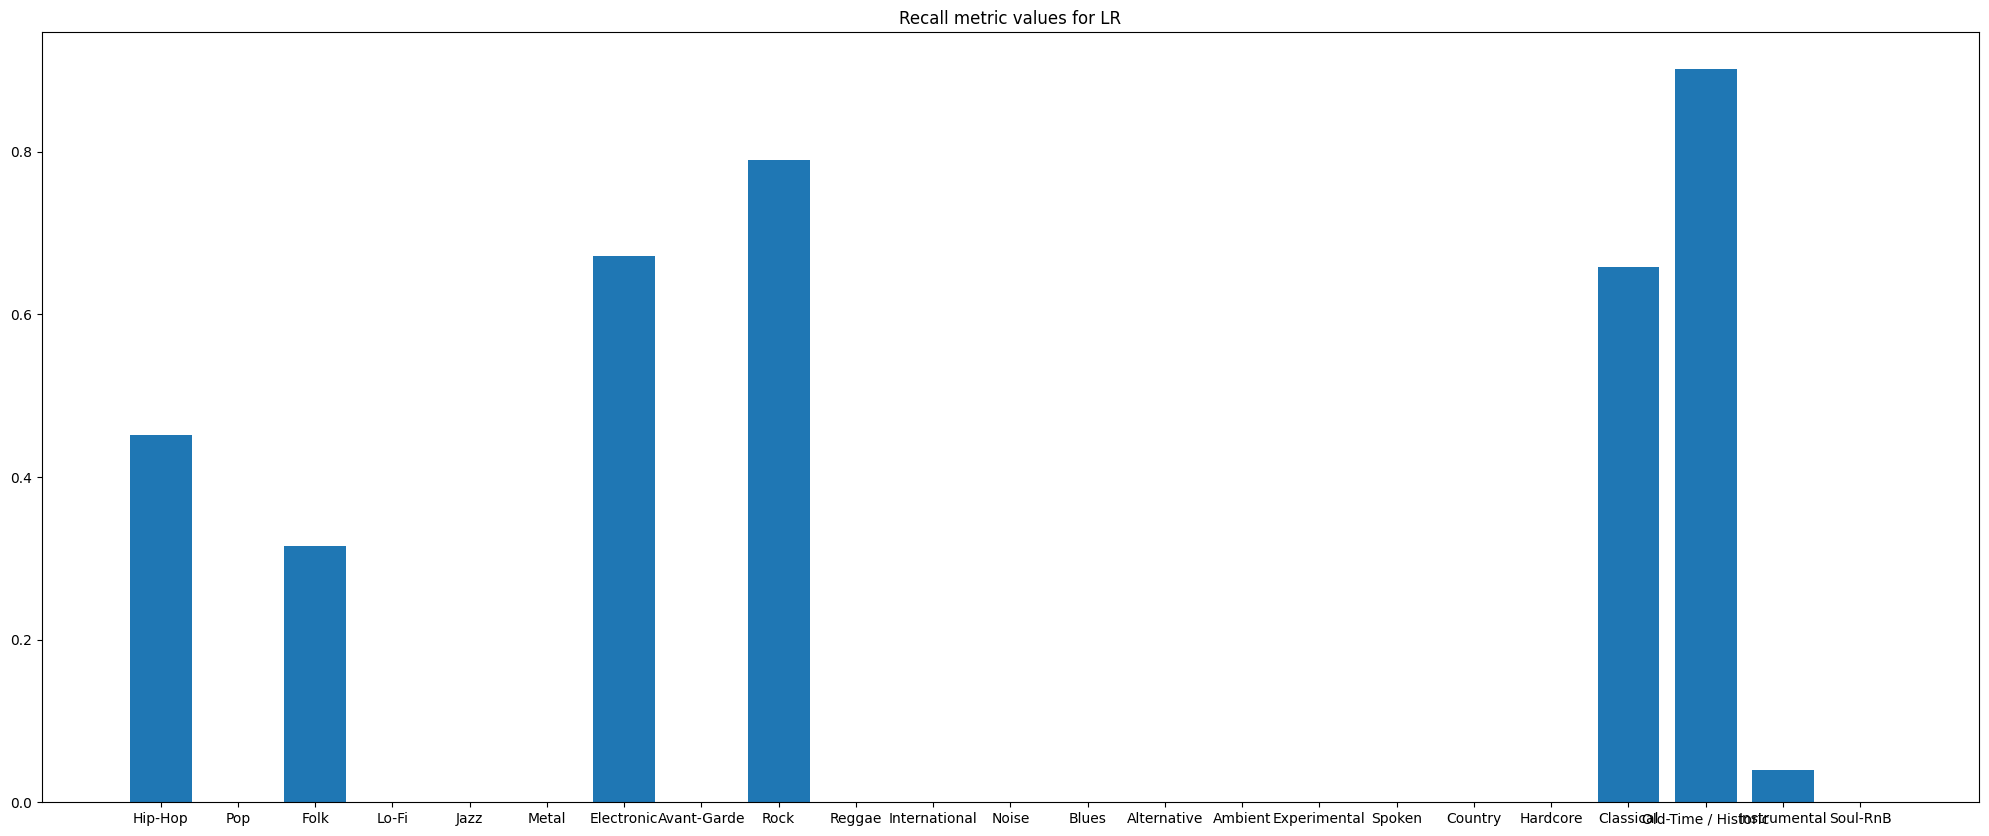

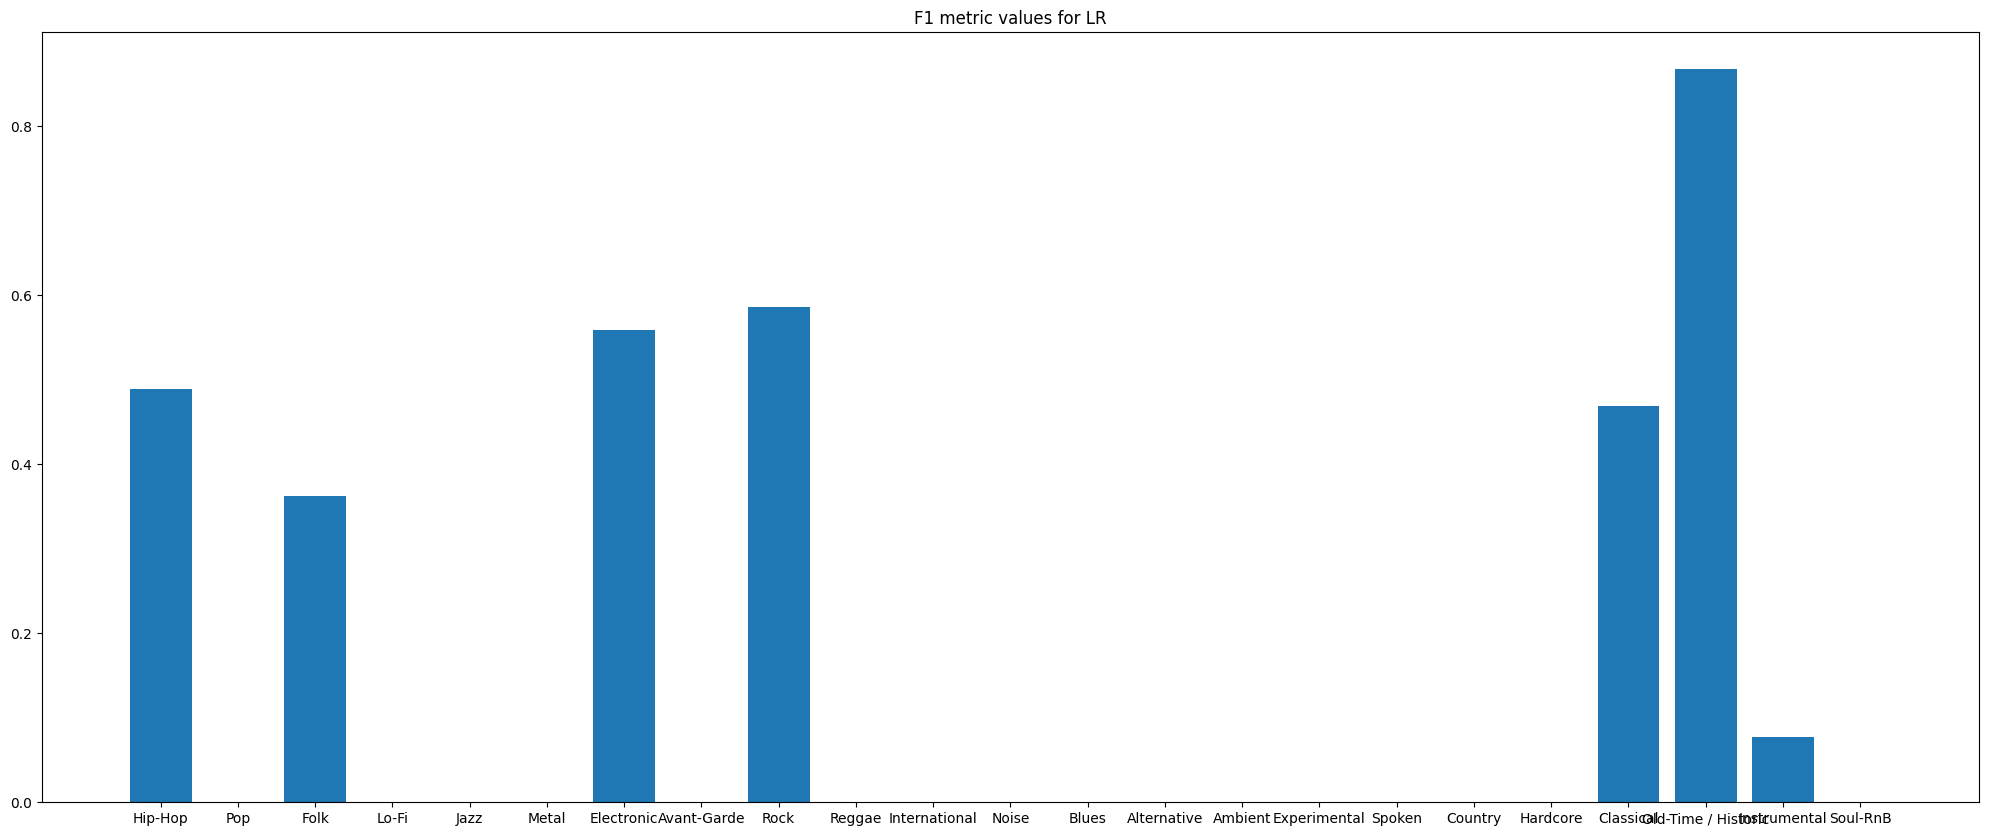

---------------------------------------------------------------------------------------

Multi Layer Perceptron results: 


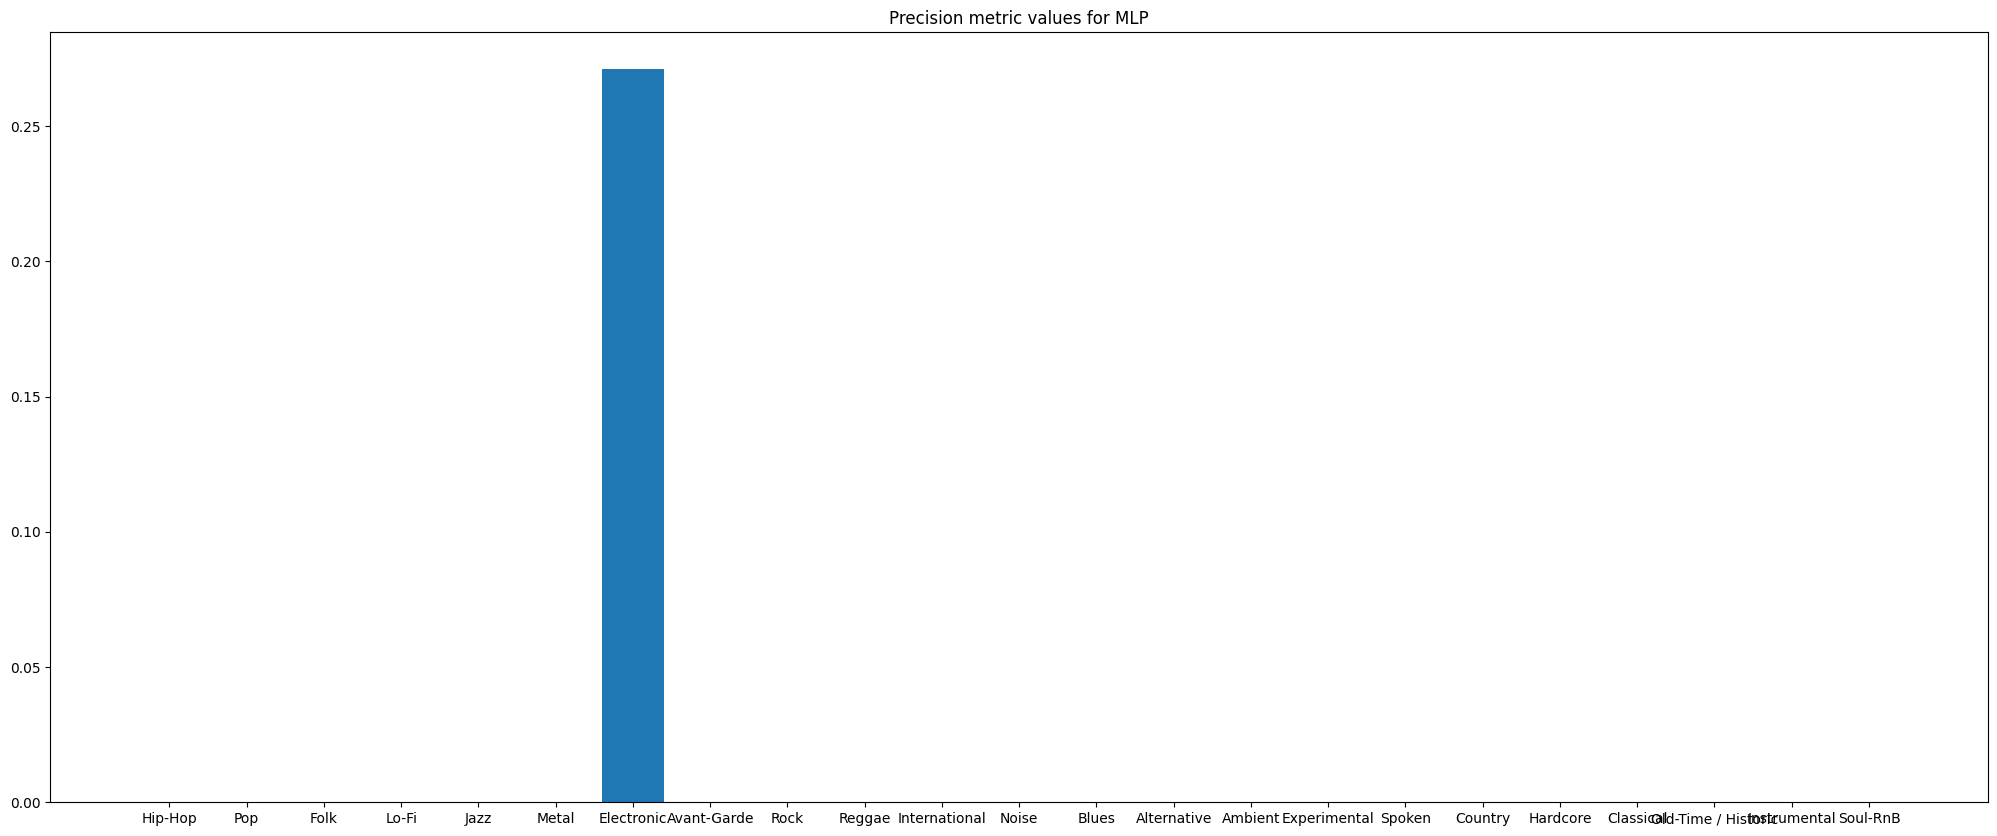

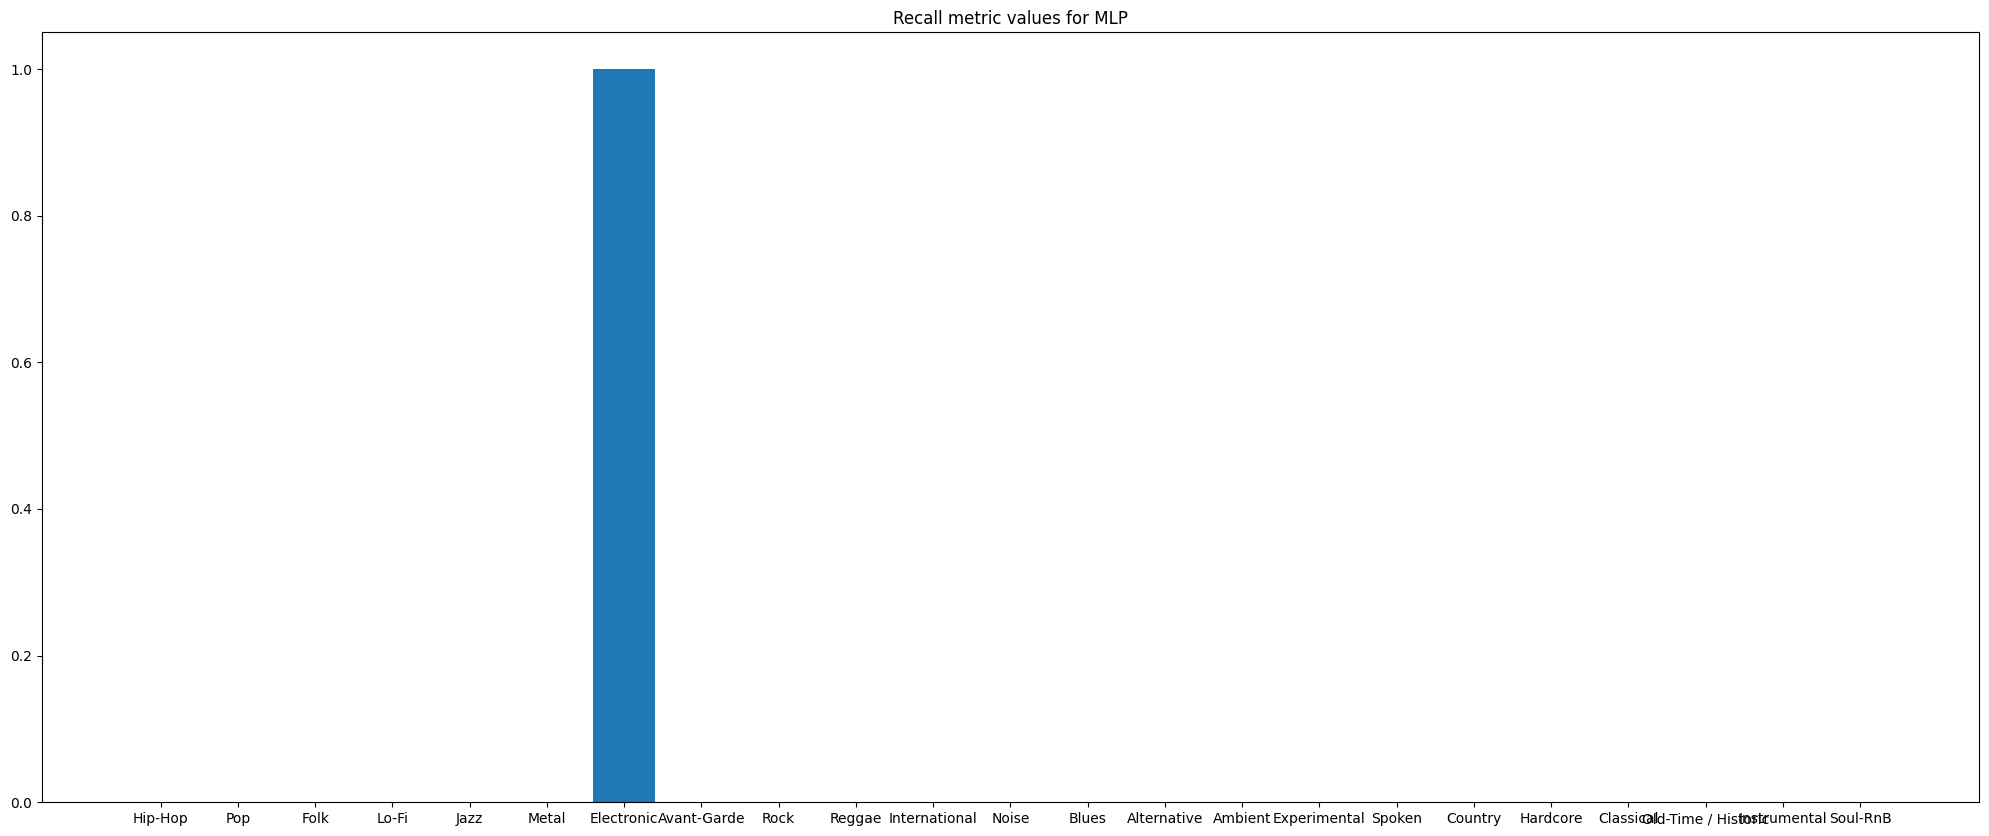

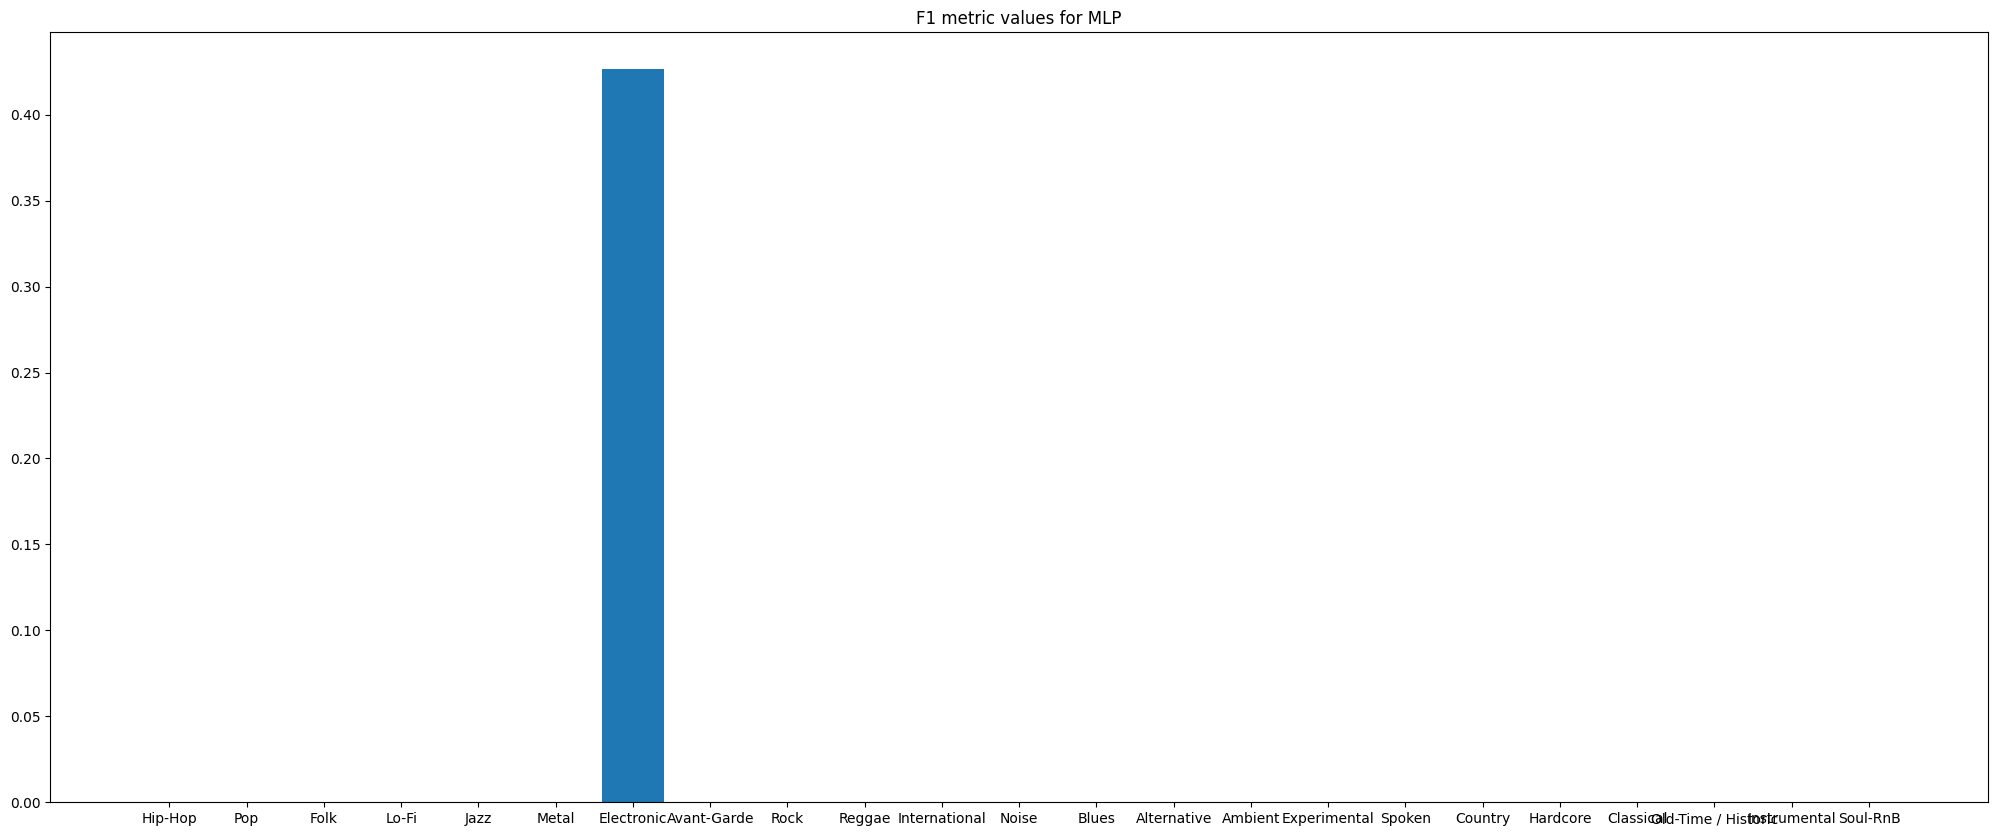

---------------------------------------------------------------------------------------



In [17]:
# TODO: confusion matrix displays wrong label order

np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
orig_labels = le.inverse_transform(labels)

print("---------------------------------------------------------------------------------------\n")
print("SVM results:")

#print("    Accuracy: ", "{:.2f}".format(accuracy_score(y_test, svm_preds)))
bar_plot((25,10), svm_precision, orig_labels, 'Precision metric values for SVM')
bar_plot((25,10), svm_recall, orig_labels, 'Recall metric values for SVM')
bar_plot((25,10), svm_f1, orig_labels, 'F1 metric values for SVM')


# Confusion matrix for SVM
#svm_cm = confusion_matrix(y_test, svm_predictions)
'''
cm_display = ConfusionMatrixDisplay(confusion_matrix = svm_cm, display_labels = labels) 
plt.figure(figsize=(30,20))
cm_display.plot()
plt.show()
'''


print("---------------------------------------------------------------------------------------\n")

print("kNN results: ")
bar_plot((25,10), knn_precision, orig_labels, 'Precision metric values for kNN')
bar_plot((25,10), knn_recall, orig_labels, 'Recall metric values for kNN')
bar_plot((25,10), knn_f1, orig_labels, 'F1 metric values for kNN')

'''
# Confusion matrix for kNN
#knn_cm = confusion_matrix(y_test, knn_predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix = knn_cm, display_labels = labels) 
plt.figure(figsize=(30,20))
cm_display.plot()
plt.show()
'''

print("---------------------------------------------------------------------------------------\n")

print("Linear Regression results: ")
bar_plot((25,10), lr_precision, orig_labels, 'Precision metric values for LR')
bar_plot((25,10), lr_recall, orig_labels, 'Recall metric values for LR')
bar_plot((25,10), lr_f1, orig_labels, 'F1 metric values for LR')
'''
# Confusion matrix for LR
#lr_cm = confusion_matrix(y_test, lr_predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix = lr_cm, display_labels = labels) 
plt.figure(figsize=(30,20))
cm_display.plot()
plt.show()
'''

print("---------------------------------------------------------------------------------------\n")
print("Multi Layer Perceptron results: ")
bar_plot((25,10), mlp_precision, orig_labels, 'Precision metric values for MLP')
bar_plot((25,10), mlp_recall, orig_labels, 'Recall metric values for MLP')
bar_plot((25,10), mlp_f1, orig_labels, 'F1 metric values for MLP')
'''
# Confusion matrix for SVM
#mlp_cm = confusion_matrix(y_test, mlp_predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix = mlp_cm, display_labels = labels) 
plt.figure(figsize=(30,20))
cm_display.plot()
plt.show()
'''

print("---------------------------------------------------------------------------------------\n")

In [ ]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

print("---------------------------------------------------------------------------------------\n")
print("SVM results:")

bar_plot((25,10), svm_precision_fma, labels, 'Precision metric values for SVM')
bar_plot((25,10), svm_recall_fma, labels, 'Recall metric values for SVM')
bar_plot((25,10), svm_f1_fma, labels, 'F1 metric values for SVM')

'''
# Confusion matrix for SVM
#svm_cm = confusion_matrix(y_test, svm_predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix = svm_cm, display_labels = labels) 
plt.figure(figsize=(30,20))
cm_display.plot()
plt.show()
'''


print("---------------------------------------------------------------------------------------\n")

print("kNN results: ")
bar_plot((25,10), knn_precision_fma, labels, 'Precision metric values for kNN')
bar_plot((25,10), knn_recall_fma, labels, 'Recall metric values for kNN')
bar_plot((25,10), knn_f1_fma, labels, 'F1 metric values for kNN')

'''
# Confusion matrix for kNN
#knn_cm = confusion_matrix(y_test, knn_predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix = knn_cm, display_labels = labels) 
plt.figure(figsize=(30,20))
cm_display.plot()
plt.show()
'''

print("---------------------------------------------------------------------------------------\n")

print("Linear Regression results: ")
bar_plot((25,10), lr_precision_fma, labels, 'Precision metric values for LR')
bar_plot((25,10), lr_recall_fma, labels, 'Recall metric values for LR')
bar_plot((25,10), lr_f1_fma, labels, 'F1 metric values for LR')
'''
# Confusion matrix for LR
#lr_cm = confusion_matrix(y_test, lr_predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix = lr_cm, display_labels = labels) 
plt.figure(figsize=(30,20))
cm_display.plot()
plt.show()
'''

print("---------------------------------------------------------------------------------------\n")
print("Multi Layer Perceptron results: ")
bar_plot((25,10), mlp_precision_fma, labels, 'Precision metric values for MLP')
bar_plot((25,10), mlp_recall_fma, labels, 'Recall metric values for MLP')
bar_plot((25,10), mlp_f1_fma, labels, 'F1 metric values for MLP')
'''
# Confusion matrix for SVM
#mlp_cm = confusion_matrix(y_test, mlp_predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix = mlp_cm, display_labels = labels) 
plt.figure(figsize=(30,20))
cm_display.plot()
plt.show()
'''

print("---------------------------------------------------------------------------------------\n")

## Conclusions
Conclusioni tipo:
- "miglior" classificatore
- limiti e difficoltà incontrare
- etc...

## Bibliography
1. [FMA paper](https://arxiv.org/abs/1612.01840)